<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/snehahs03/medical-image-analysis.git

Cloning into 'medical-image-analysis'...
remote: Enumerating objects: 3763, done.
remote: Total 3763 (delta 0), reused 0 (delta 0), pack-reused 3763
Receiving objects: 100% (3763/3763), 336.87 MiB | 37.47 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (3889/3889), done.


In [ ]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from tqdm import tqdm
from sklearn import metrics
from collections import Counter
import json
import itertools
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten

In [ ]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [ ]:
eczema_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Eczema Photos", 224))
melanoma_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Psoriasis pictures Lichen Planus and related diseases",224))
eczema_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Eczema Photos",224))
melonoma_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Psoriasis pictures Lichen Planus and related diseases", 224))


100%|██████████| 352/352 [00:02<00:00, 163.71it/s]


In [ ]:
#labelling 
eczema_train_label = np.full(len(eczema_train),0)
melonoma_train_label = np.full(len(melanoma_train),1)
psoriasis_train_label = np.full(len(psoriasis_train),2)
eczema_test_label = np.full(len(eczema_test),0)
melonoma_test_label = np.full(len(melonoma_test),1)
psoriasis_test_label = np.full(len(psoriasis_test),2)

In [ ]:
X_train = np.concatenate((eczema_train, melanoma_train, psoriasis_train), axis=0)
Y_train = np.concatenate((eczema_train_label, melonoma_train_label, psoriasis_train_label), axis=0)
X_test = np.concatenate((eczema_test, melonoma_test, psoriasis_test), axis=0)
Y_test = np.concatenate((eczema_test_label, melonoma_test_label, psoriasis_test_label), axis = 0)
print(Y_test.shape)
print(X_test.shape)

(777,)
(777, 224, 224, 3)


In [ ]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [ ]:
Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

#train and evaluation split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.3, 
    random_state=5
)

In [ ]:
X_train.shape, Y_train.shape

((2172, 224, 224, 3), (2172, 3))

In [ ]:
X_val.shape, Y_val.shape

((931, 224, 224, 3), (931, 3))

In [ ]:
X_test.shape, Y_test.shape

((777, 224, 224, 3), (777, 3))

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
#load in pretrained model
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
#adding output layer
top_model = vgg.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(3, activation='softmax')(top_model)

In [ ]:
#create a model object
model = Model(inputs=vgg.input, outputs=output_layer)

In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#Feature extraction
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
val_datagen.fit(X_val)


In [ ]:
batch_size = 64
epochs = 5
history = model.fit_generator(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
67/67 [==============================] - 84s 552ms/step - loss: 12.3420 - accuracy: 0.4475 - val_loss: 1.7911 - val_accuracy: 0.5851
Epoch 2/5
67/67 [==============================] - 31s 462ms/step - loss: 1.8260 - accuracy: 0.5507 - val_loss: 1.0383 - val_accuracy: 0.5991
Epoch 3/5
67/67 [==============================] - 32s 471ms/step - loss: 1.1429 - accuracy: 0.5987 - val_loss: 0.8806 - val_accuracy: 0.6002
Epoch 4/5
67/67 [==============================] - 31s 462ms/step - loss: 0.8231 - accuracy: 0.6286 - val_loss: 0.8045 - val_accuracy: 0.6412
Epoch 5/5
67/67 [==============================] - 32s 472ms/step - loss: 0.8179 - accuracy: 0.6282 - val_loss: 0.8316 - val_accuracy: 0.6078


In [ ]:
#Fine-Tuning 

for layer in model.layers[:5]:
    layer.trainable = False

for layer in model.layers[5:]:
    layer.trainable = True

In [ ]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [ ]:
batch_size = 64
epochs = 20
history = model.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

Epoch 1/20
33/33 [==============================] - 62s 1s/step - loss: 1.0632 - acc: 0.4961 - val_loss: 0.9479 - val_acc: 0.4643
Epoch 2/20
33/33 [==============================] - 30s 901ms/step - loss: 0.9281 - acc: 0.5121 - val_loss: 0.8690 - val_acc: 0.5536
Epoch 3/20
33/33 [==============================] - 30s 907ms/step - loss: 0.8854 - acc: 0.5538 - val_loss: 0.8191 - val_acc: 0.6049
Epoch 4/20
33/33 [==============================] - 30s 901ms/step - loss: 0.8345 - acc: 0.6003 - val_loss: 0.8174 - val_acc: 0.5982
Epoch 5/20
33/33 [==============================] - 30s 907ms/step - loss: 0.7870 - acc: 0.6115 - val_loss: 0.7450 - val_acc: 0.6362
Epoch 6/20
33/33 [==============================] - 30s 902ms/step - loss: 0.7489 - acc: 0.6363 - val_loss: 0.7669 - val_acc: 0.6362
Epoch 7/20
33/33 [==============================] - 30s 903ms/step - loss: 0.7025 - acc: 0.6709 - val_loss: 0.7239 - val_acc: 0.6451
Epoch 8/20
33/33 [==============================] - 30s 909ms/step - los

In [ ]:
loss_val, acc_val = model.evaluate(X_val, Y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

30/30 [==============================] - 5s 160ms/step - loss: 0.6626 - acc: 0.7368
Validation: accuracy = 0.736842  ;  loss_v = 0.662637


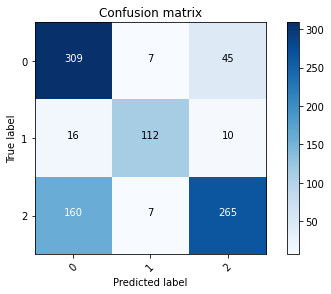

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

TESTING


In [ ]:
loss_test, acc_test = model.evaluate(X_test, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

25/25 [==============================] - 5s 218ms/step - loss: 0.6342 - acc: 0.7465
Test: accuracy = 0.746461  ;  loss = 0.634228


Text(0.5, 1.0, 'Training and validation loss')

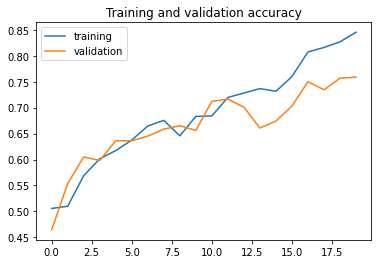

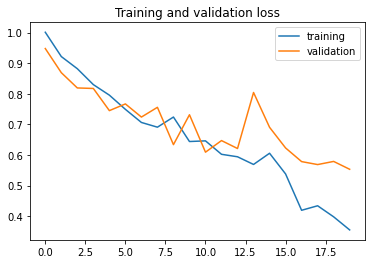

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

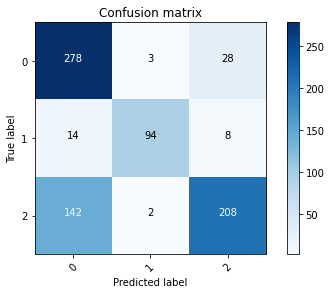

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))